# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

Let's generate our dataset and take a look on it.

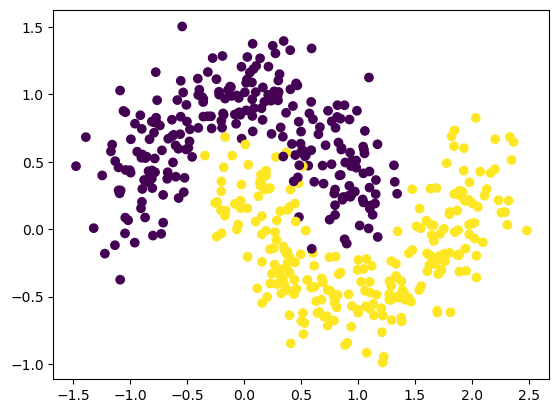

In [2]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)

In [3]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

In [4]:
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions

X_train, X_test, y_train, y_test = train_test_split(moons_points, moons_labels, test_size=0.35, stratify=moons_labels)


def score_all(models, labels):
    for i, label in enumerate(labels):
        print(f'{label} accuracy: {accuracy_score(y_test, models[i].fit(X_train, y_train).predict(X_test))}')

    grids = gridspec.GridSpec(3, 3)
    plt.figure(figsize=(15, 12))

    for clf, label, grid in zip(models, labels, itertools.product([0, 1, 2], repeat=2)):
        plt.subplot(grids[grid[0], grid[1]])
        plot_decision_regions(X=X_train, y=y_train, clf=clf, legend=2)
        plt.title(label)

    plt.show()

LogReg accuracy: 0.8171428571428572
Linear kernel SVM accuracy: 0.8171428571428572


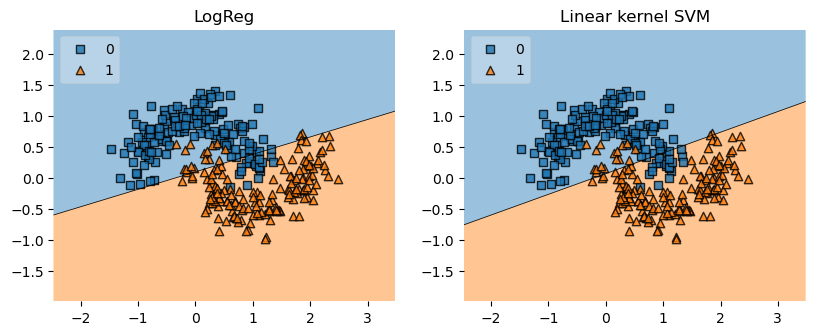

In [5]:
from sklearn.metrics import accuracy_score
import itertools
from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

logreg_pipeline = make_pipeline(StandardScaler(),
                                LogisticRegression(multi_class='multinomial', solver='saga', tol=1e-4, max_iter=1000,
                                                   class_weight='balanced'))
svm_pipeline = make_pipeline(StandardScaler(),
                             SVC(kernel='linear', gamma='auto', degree=5, class_weight='balanced', shrinking=True))

logreg_pipeline.fit(X_train, y_train)
logreg_preds = logreg_pipeline.predict(X_test)

svm_pipeline.fit(X_train, y_train)
svm_preds = svm_pipeline.predict(X_test)

score_all([logreg_pipeline, svm_pipeline], ['LogReg', 'Linear kernel SVM'])

Both classifiers clearly are unable to sufficiently solve this task, because they both try to find a $\textit{linear}$ hyperspace that separates the two classes, which cannot be done with a high accuracy in this case, because no linear hyperspace divides the two classes.

## 1.2 Kernel tirck

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

RBF kernel accuracy: 0.96
Poly kernel accuracy: 0.9714285714285714
Sigmoid kernel accuracy: 0.8685714285714285


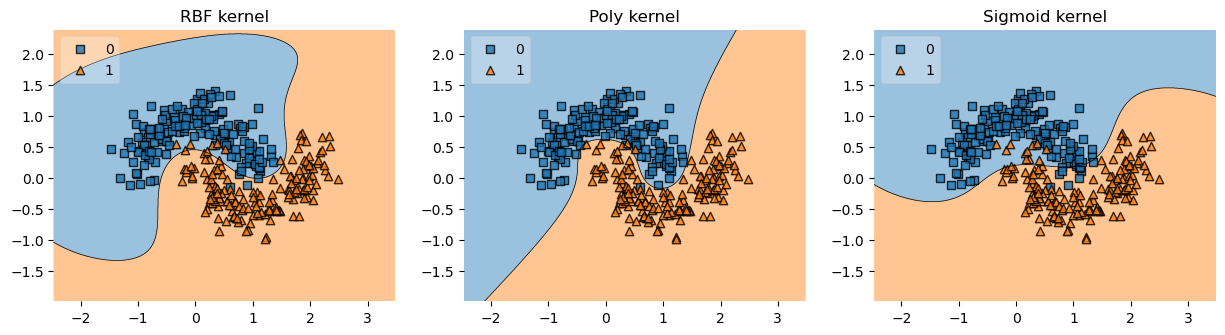

In [6]:
rbf_pipeline = make_pipeline(StandardScaler(),
                             SVC(kernel='rbf', gamma='auto', degree=5, tol=1e-3, max_iter=1000, shrinking=True))

poly_pipeline = make_pipeline(StandardScaler(),
                              SVC(kernel='poly', gamma='auto', degree=9, coef0=1, tol=1e-4, max_iter=1000,
                                  shrinking=True))

sigm_pipeline = make_pipeline(StandardScaler(),
                              SVC(kernel='sigmoid', gamma='auto', degree=15, coef0=-1.5, tol=1e-5, max_iter=1000,
                                  shrinking=True))

score_all([rbf_pipeline, poly_pipeline, sigm_pipeline], ['RBF kernel', 'Poly kernel', 'Sigmoid kernel'])

The quality has significantly increased, because we used the types of classifiers that look for more complex border types to divide the two classes.
The decision border now has a complex structure, in the case of the RBF kernel it even became a closed curve.
All the parameters were determined empirically by running the code many times with different parameters and comparing the scores.

## 1.3 Simpler solution (of a kind)
What if we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

LogReg with polynomial featured accuracy: 0.9657142857142857
SVM with poly kernel accuracy: 0.9657142857142857


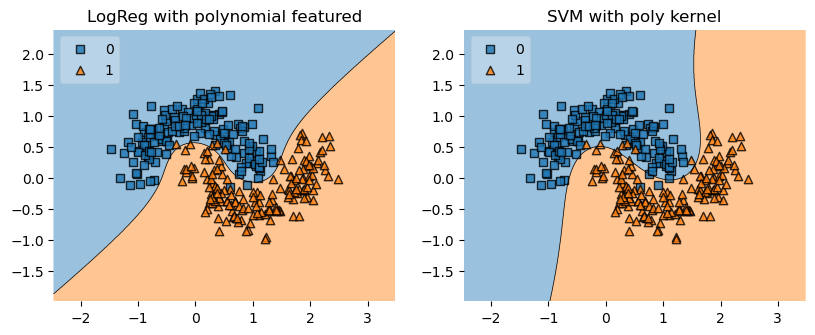

In [7]:
from sklearn.preprocessing import PolynomialFeatures

logreg_polynomial_pipeline = make_pipeline(StandardScaler(),
                                           PolynomialFeatures(degree=3),
                                           LogisticRegression(multi_class='multinomial', solver='saga', tol=1e-4,
                                                              max_iter=1000, class_weight='balanced'))

svm_pipeline = make_pipeline(StandardScaler(),
                             SVC(kernel='poly', gamma='scale', degree=3, coef0=5, tol=1e-4, max_iter=1000,
                                 shrinking=True))

score_all([logreg_polynomial_pipeline, svm_pipeline], ['LogReg with polynomial featured', 'SVM with poly kernel'])

Using the same degree of polynomial features for the logistic regression as we did for the SVM with poly kernel proved to produce the best result, which is equal to the one produced by the SVM. This is caused by the same reason that caused the decision tree forest to produce the same result as the bagging of decision trees in the previous part of this assignment: the two classifiers are basically the same thing with very minor differences.

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

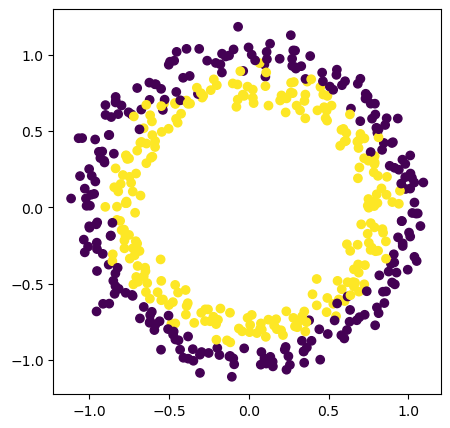

In [8]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)

And even more:

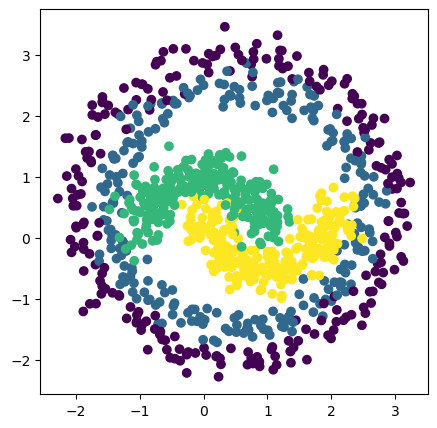

In [9]:
hard_points = np.vstack((circles_points * 2.5 + 0.5, moons_points))
hard_labels = np.hstack((circles_labels, moons_labels + 2))  # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(hard_points[:, 0], hard_points[:, 1], c=hard_labels)

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(hard_points, hard_labels, test_size=0.35, stratify=hard_labels)

LogReg with polynomial featured accuracy: 0.8828571428571429
SVM with RBF kernel accuracy: 0.8971428571428571
SVM with poly kernel accuracy: 0.88
SVM with sigmoid kernel accuracy: 0.8342857142857143
Random forest accuracy: 0.9028571428571428


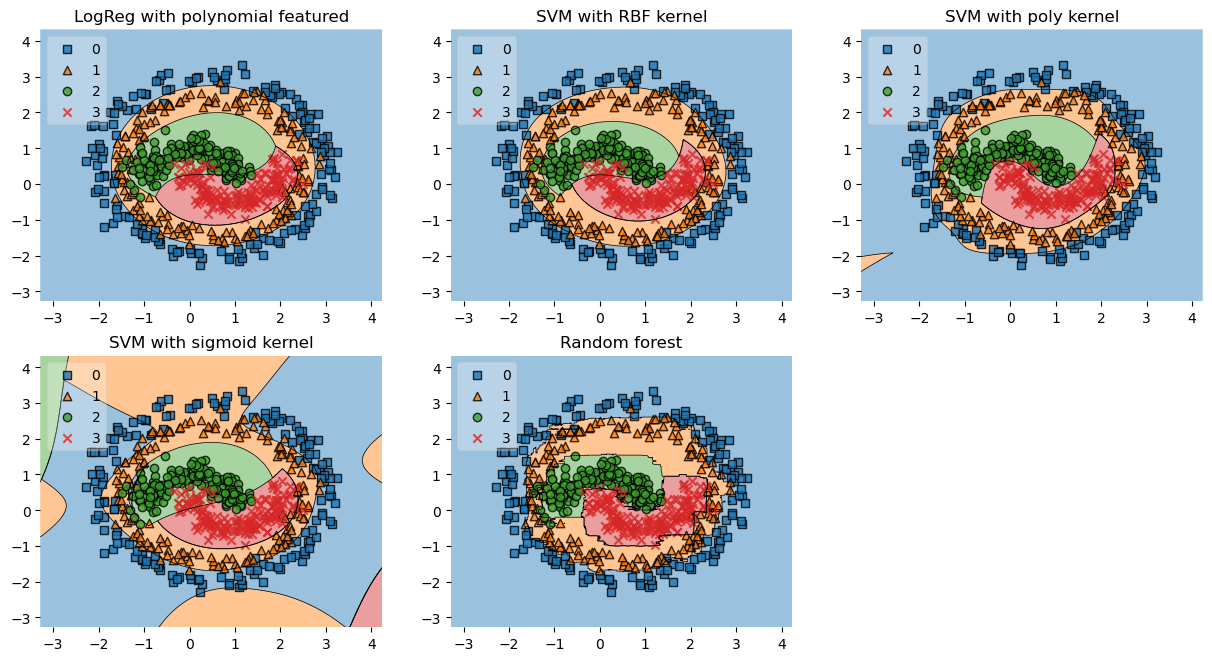

In [11]:
from sklearn.ensemble import RandomForestClassifier

logreg_pipeline = make_pipeline(StandardScaler(),
                                PolynomialFeatures(degree=3),
                                LogisticRegression(multi_class='multinomial', solver='saga', tol=1e-4, max_iter=1000,
                                                   class_weight='balanced'))

svm_rbf_pipeline = make_pipeline(StandardScaler(),
                                 SVC(kernel='rbf', gamma='auto', degree=5, tol=1e-3, max_iter=1000, shrinking=True))

svm_poly_pipeline = make_pipeline(StandardScaler(),
                                  SVC(kernel='poly', gamma='auto', degree=9, coef0=1, tol=1e-4, max_iter=1000,
                                      shrinking=True))

svm_sigm_pipeline = make_pipeline(StandardScaler(),
                                  SVC(kernel='sigmoid', gamma='auto', degree=15, coef0=-1.5, tol=1e-5, max_iter=1000,
                                      shrinking=True))

forest_pipeline = make_pipeline(StandardScaler(),
                                RandomForestClassifier())

score_all(
    [logreg_pipeline, svm_rbf_pipeline, svm_poly_pipeline, svm_sigm_pipeline, forest_pipeline],
    ['LogReg with polynomial featured', 'SVM with RBF kernel', 'SVM with poly kernel', 'SVM with sigmoid kernel',
     'Random forest']
)

The random forest proved to produce the best scores. This can be explained by the fact that while other methods look for a complex border to divide the classes, they still look for a $\textit{smooth}$ one. That does not apply to the random forest. Actually, the opposite is true: the border provided by the forest will almost never be smooth, because of the branching and making individual decisions for each (or each small batch) of the samples. This property allowed the random forest to show the highest scores in a task, where the classes are very close to each other and sometimes eve intertwined, because the forest was able to pinpoint the details of the border, something other methods cannot due to the fact that they only consider smooth borders.